In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 

In [9]:
#User enters data here
file = 'GCData-JGI_ACRs w Conc Data.xlsx' #file name
sheet = 'Corrected Concentration' #sheet with corrected concentration data
samples = ['A10','A12','B12','C10','C11','C12','D10','E11','H9','H10','H12','MaACR','Neg','Rec'] #name of samples
### ^^Do these have to be in order? 
### ^^Yes, they have to be in order of appearance. I'm trying to see if I can get that fixed
numVials = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!') #love it

chains = ['C4','C6', 'C8','C10','C12','C14','C16'] #chain lengths

#Graph options
title = 'JGI ACR Homolog' #graph title
ylabel = 'mg/L FaOH' #y axis label
graphWidth = 9 #Default 6.0
graphHeight = 4 #Default 4.0
barWidth = 0.8 #Default 0.8
legendLocation = 'upper left' #Default 'best' or Choose: 'upper right/center/left', 'lower right/center/left' 
plt.rcParams["font.family"] = "Times New Roman"
### Python Default
#plt.rcParams["font.family"] = "DejaVu Sans"

In [10]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

In [11]:
#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

In [12]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+2]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = np.std(rearranged[0][r][c*3:(c*3)+2])
        
    return avgMat,stdevMat

In [13]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, title, ylabel):
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)

    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    plt.figure(figsize=(graphWidth,graphHeight))
    fistplot = plt.bar(ind, firstMean, width=barWidth, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width=barWidth, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,samples)
    plt.legend(loc=legendLocation)
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show

In [14]:
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheet_name=sheet)
    correctedConc = []
    title = df[0][0].split('-')[0]
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        sample = df[0][i] if isinstance(df[0][i], float) else df[0][i].split('-')[0]
        if isinstance(sample, str) and not sample == 'Peak#':
            title = sample
        if title in samples and isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
    return correctedConc

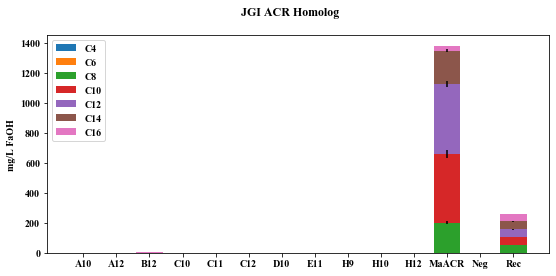

In [15]:
createBarChart(file, sheet, samples, numVials, chains, title, ylabel)